In [1]:
from datasets import load_dataset

data = load_dataset(
    "jamescalam/reddit-topics",
    split="train",
    revision="c14d532"
    )
data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc'],
    num_rows: 3791
})

In [2]:
data = data.filter(lambda x: True if len(x['selftext']) > 30 else 0)
data

Filter:   0%|          | 0/3791 [00:00<?, ? examples/s]

Dataset({
    features: ['sub', 'title', 'selftext', 'upvote_ratio', 'id', 'created_utc'],
    num_rows: 3118
})

In [3]:
data = data.shuffle()

In [4]:
n = len(data)

## 1. Embedding

The first step is embedding with a sentence transformer model. We're doing this for relatively generic data and we will not be fine-tuning a model so we will use one of the better off-the-shelf sentence transformers the sentence-transformers library.

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

Then we create embeddings, we do this in batches.

In [7]:
import numpy as np
from tqdm.auto import tqdm

batch_size = 16

embeds = np.zeros((n, model.get_sentence_embedding_dimension()))

for i in tqdm(range(0, n, batch_size)):
    i_end = min(i+batch_size, n)
    batch = data['selftext'][i:i_end]
    batch_embed = model.encode(batch)
    embeds[i:i_end,:] = batch_embed

  0%|          | 0/195 [00:00<?, ?it/s]

Now we can move onto dim reduction and clustering...

## UMAP Dimensionality Reduction
We'll start by testing with several UMAP parameters and visualizing the results.

In [8]:
set(data['sub'][:n])

{'LanguageTechnology', 'Python', 'investing', 'pytorch'}

In [11]:
colors = data['sub'][:n]
c_map = {
    'LanguageTechnology': '#FAFF00',
    'Python': '#1C17FF',
    'investing': '#738FAB',
    'pytorch': '#8CF1FF'
}
colors = [c_map[x] for x in colors]
colors[:3]

['#FAFF00', '#FAFF00', '#8CF1FF']

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\spectral.py:260: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Pytho

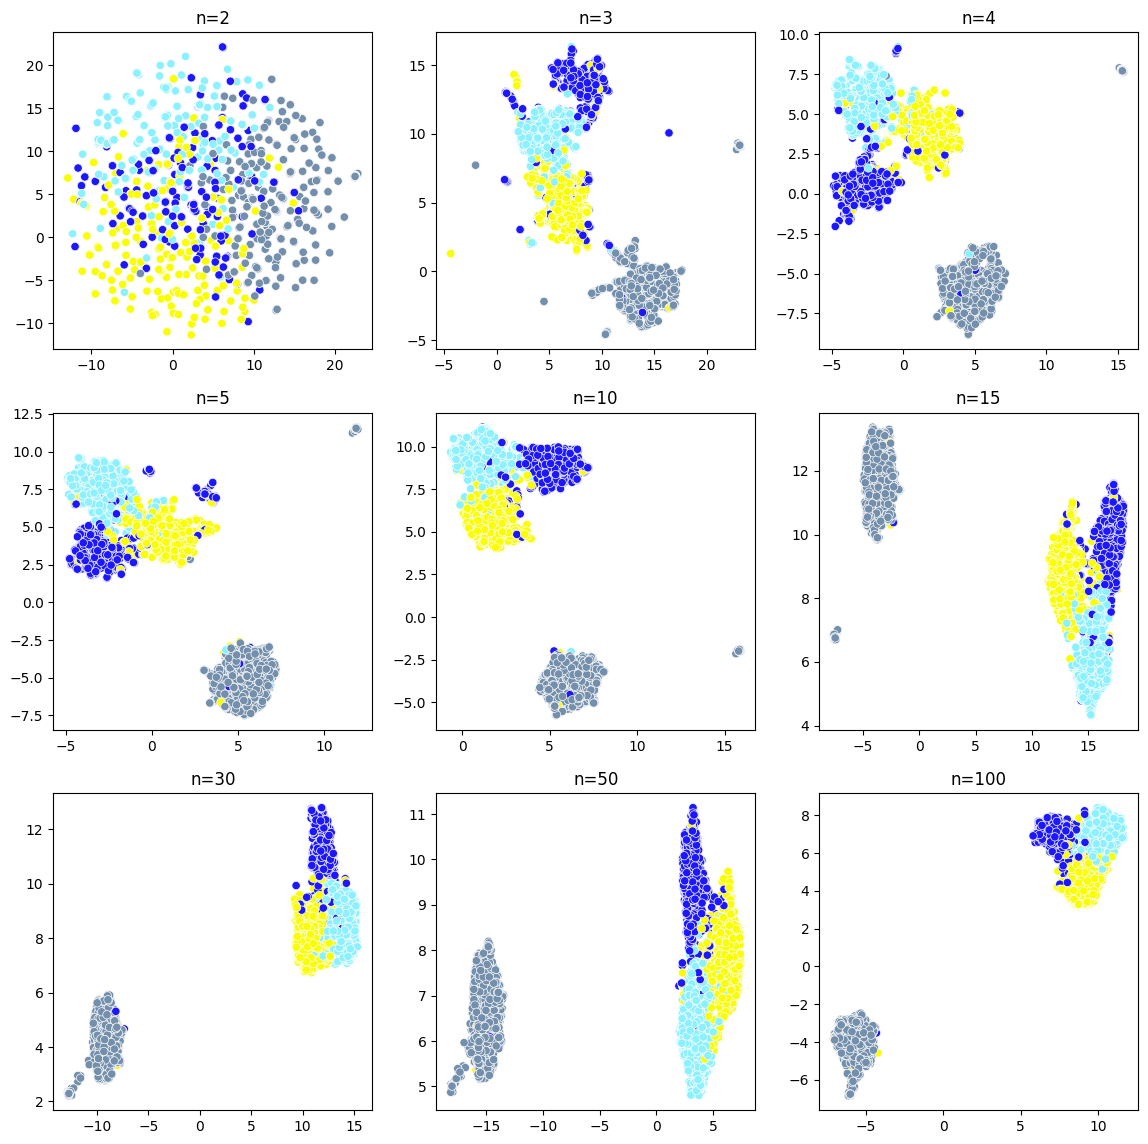

In [12]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(3, 3, figsize=(14, 14))
nns = [2, 3, 4, 5, 10, 15, 30, 50, 100]
i, j = 0, 0
for n_neighbors in tqdm(nns):
    fit = umap.UMAP(n_neighbors=n_neighbors)
    u = fit.fit_transform(embeds)
    sns.scatterplot(x=u[:,0], y=u[:,1], c=colors, ax=ax[j, i])
    ax[j, i].set_title(f'n={n_neighbors}')
    if i < 2: i += 1
    else: i = 0; j += 1

Using labels to train the model, a n_neighbors of 3 to 5 seem to perform best, we can increase the number of dimensions up to 3D and test a few more parameters, one of the strongest splits seems to be using n_neighbors=3 and min_dist=0.05.

In [14]:
import plotly.express as px

fit = umap.UMAP(n_neighbors=3, n_components=3, min_dist=0.05)
u = fit.fit_transform(embeds)

fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    color=colors,
    custom_data=[data['sub'][:n], data['title'][:n]]
)
fig.update_traces(
    hovertemplate="<br>".join([
        "sub: %{customdata[1]}",
        "title: %{customdata[0]}"
    ])
)

## Clustering with HDBSCAN

We can only view our clusters using existing labels, but if we want to predict topics for new inputs we need to be able to cluster automatically.

To do this we use HDBSCAN like so:

In [15]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(u)

HDBSCAN()

<AxesSubplot: ylabel='$\\lambda$ value'>

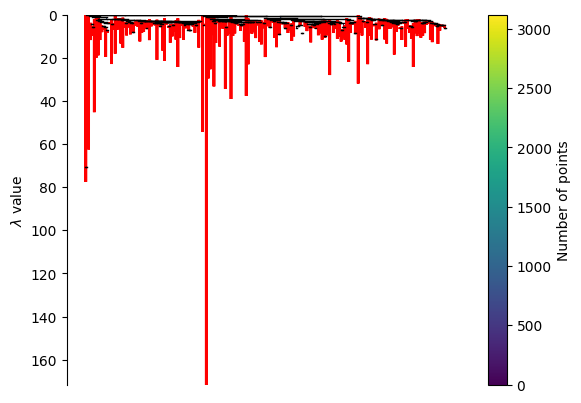

In [16]:
clusterer.condensed_tree_.plot(select_clusters=True)

Using the condensed tree plot we can see we have what seem to be too many clusters, we can increase the min_cluster_size to merge the smaller clusters (like those on the right).

<AxesSubplot: ylabel='$\\lambda$ value'>

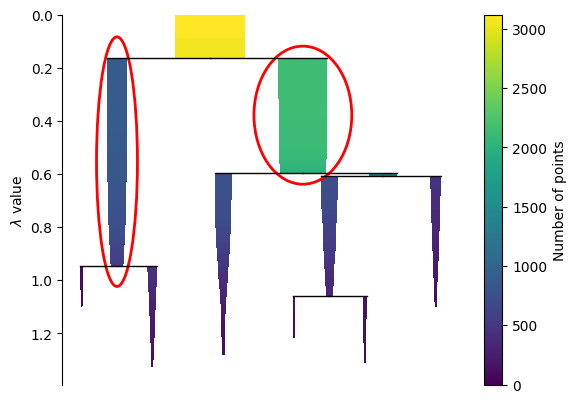

In [21]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80)
clusterer.fit(u)

clusterer.condensed_tree_.plot(select_clusters=True)

Not quite there we can try and reduce the min_cluster_size to pull in the three clusters below the green block.

<AxesSubplot: ylabel='$\\lambda$ value'>

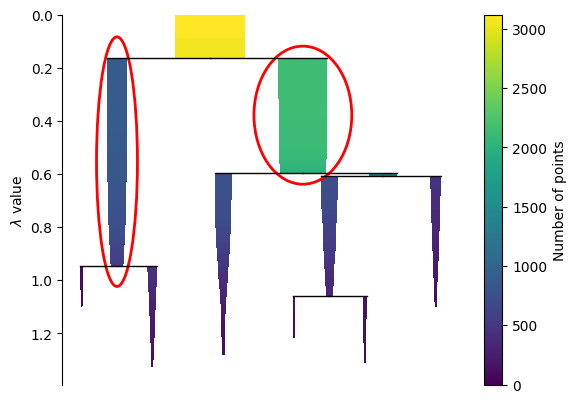

In [22]:
cluster = hdbscan.HDBSCAN(
    min_cluster_size=60)
clusterer.fit(u)

clusterer.condensed_tree_.plot(select_clusters=True)

In [9]:
from datasets import load_dataset

geo = load_dataset('jamescalam/world-cities-geo', split='train')
geo

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['city', 'country', 'region', 'continent', 'latitude', 'longitude', 'x', 'y', 'z'],
    num_rows: 9083
})

In [10]:
import plotly.express as px

palette = ['#1c17ff', '#faff00', '#8cf1ff', '#000000', '#030080', '#738fab']

fig = px.scatter_3d(
    x=geo['x'], y=geo['y'], z=geo['z'],
    color=geo['continent'],
    custom_data=[geo['country'], geo['city']],
    color_discrete_sequence=palette
)
fig.update_traces(
    hovertemplate="\n".join([
        "city: %{customdata[1]}",
        "country: %{customdata[0]}"
    ])
)

In [ ]:
fig.write_html